# Построение моделей для прогноза модуля упругости при растяжении и прочности при растяжении

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from pandas import read_excel, DataFrame, Series
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from numpy.random import seed
from scipy import stats

%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings(action='ignore')

Некоторые ML алгоритмы требуют нормализации данных, поэтому в первую очередь обучим модель на нормализованных данных.

In [28]:
df_clean = pd.read_csv('Datasets/df_clean.csv')
df_clean.head()

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
1,3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
2,4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
3,5,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
4,6,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


In [29]:
df_elastic = df_clean.drop(['Модуль упругости при растяжении, ГПа', 'Unnamed: 0'], axis=1)
df_elastic.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,3000.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,3000.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,3000.0,220.0,0,5.0,57.0


In [30]:
df_strength = df_clean.drop(['Прочность при растяжении, МПа', 'Unnamed: 0'], axis=1)
df_strength.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,220.0,0,4.0,60.0
1,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,220.0,0,5.0,47.0
2,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,220.0,0,5.0,57.0


In [31]:
target_elastic = df_clean['Модуль упругости при растяжении, ГПа']
target_elastic.head(3)

0    70.0
1    70.0
2    70.0
Name: Модуль упругости при растяжении, ГПа, dtype: float64

In [32]:
target_strength = df_clean['Прочность при растяжении, МПа']
target_strength.head(3)

0    3000.0
1    3000.0
2    3000.0
Name: Прочность при растяжении, МПа, dtype: float64

Разбиваем данные на тестовую и обучающую выборки

In [33]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(df_elastic, target_elastic, test_size=0.3, random_state=42)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df_strength, target_strength, test_size=0.3, random_state=42)

In [34]:
print(X_train_e.shape)
print(X_test_e.shape)
print(y_train_e.shape)
print(y_test_e.shape)

print(X_train_s.shape)
print(X_test_s.shape)
print(y_train_s.shape)
print(y_test_s.shape)

(644, 12)
(277, 12)
(644,)
(277,)
(644, 12)
(277, 12)
(644,)
(277,)


In [36]:
# Проверяем правильность разбивки
df_elastic.shape[0] - X_train_e.shape[0] - X_test_e.shape[0]

0

In [37]:
X_train_e.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
481,2.579047,1968.419362,881.889313,158.205290,20.977561,290.024579,539.223505,2882.895803,172.855704,1,8.307235,62.202309
650,3.964543,1823.413785,919.728547,66.852186,21.071960,225.010399,776.757823,2986.641644,299.963678,1,4.498704,67.704663


In [38]:
X_test_e.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
319,2.544192,2062.918247,718.492638,119.924425,21.043501,237.911236,223.049480,2300.777919,242.416875,0,5.939560,78.847771
377,3.719015,1866.653447,1001.285793,153.427803,22.718403,288.133573,279.016949,3223.607474,160.304704,0,6.936649,66.339135


In [39]:
y_train_e.head(2)

481    72.313342
650    69.477494
Name: Модуль упругости при растяжении, ГПа, dtype: float64

In [40]:
y_train_s.head(2)

481    2882.895803
650    2986.641644
Name: Прочность при растяжении, МПа, dtype: float64

# Метод случайного леса

In [41]:
rfr = RandomForestRegressor()
rfr.fit(X_train_e, np.ravel(y_train_e))
y_pred_rfr_e = rfr.predict(X_test_e)
mae_rfr_e = mean_absolute_error(y_test_e, y_pred_rfr_e)
mse_rfr_e = mean_squared_error(y_test_e, y_pred_rfr_e)
print('Random Forest Regressor Results Train:')
print("Test score: {:.3f}".format(rfr.score(X_train_e, y_train_e))) # Скор для тренировочной выборки
print('Random Forest Regressor Results:')
print('rfr_MAE: ', round(mean_absolute_error(y_test_e, y_pred_rfr_e)))

print('rfr_MSE: {:.2f}'.format(mse_rfr_e))
print("rfr_RMSE: {:.2f}".format (np.sqrt(mse_rfr_e)))


print("Test score: {:.2f}".format(rfr.score(X_test_e, y_test_e))) # Скор для тестовой выборки

Random Forest Regressor Results Train:
Test score: 0.852
Random Forest Regressor Results:
rfr_MAE:  2
rfr_MSE: 9.42
rfr_RMSE: 3.07
Test score: -0.04


In [42]:
rfr_e = RandomForestRegressor(n_estimators=15, max_depth=5, random_state=42)
rfr_s = RandomForestRegressor(n_estimators=15, max_depth=5, random_state=42)
rfr_e.fit(X_train_e, np.ravel(y_train_e))
rfr_s.fit(X_train_s, np.ravel(y_train_s))

y_pred_test_rfr_e = rfr_e.predict(X_test_e)
y_pred_train_rfr_e = rfr_e.predict(X_train_e)
y_pred_test_rfr_s = rfr_s.predict(X_test_s)
y_pred_train_rfr_s = rfr_s.predict(X_train_s)

print('MSE RandomForestRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_rfr_e), mean_squared_error(y_test_e, y_pred_test_rfr_e)))
print('R^2 RandomForestRegressor train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_rfr_e), r2_score(y_test_e, y_pred_test_rfr_e)))
print('MAE RandomForestRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_rfr_e), mean_absolute_error(y_test_e, y_pred_test_rfr_e)))
print('\n')
print('MSE RandomForestRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_rfr_s), mean_squared_error(y_test_s, y_pred_test_rfr_s)))
print('R^2 RandomForestRegressor train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_rfr_s), r2_score(y_test_s, y_pred_test_rfr_s)))
print('MAE RandomForestRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_rfr_s), mean_absolute_error(y_test_s, y_pred_test_rfr_s)))

MSE RandomForestRegressor train_e: 6.9005, test_e: 9.2088
R^2 RandomForestRegressor train_e: 0.2483, test_e: -0.0145
MAE RandomForestRegressor train_e: 2.1325, test_e: 2.4773


MSE RandomForestRegressor train_s: 141389.7205, test_s: 224732.5402
R^2 RandomForestRegressor train_s: 0.2756, test_s: 0.0013
MAE RandomForestRegressor train_s: 300.0945, test_s: 384.4820


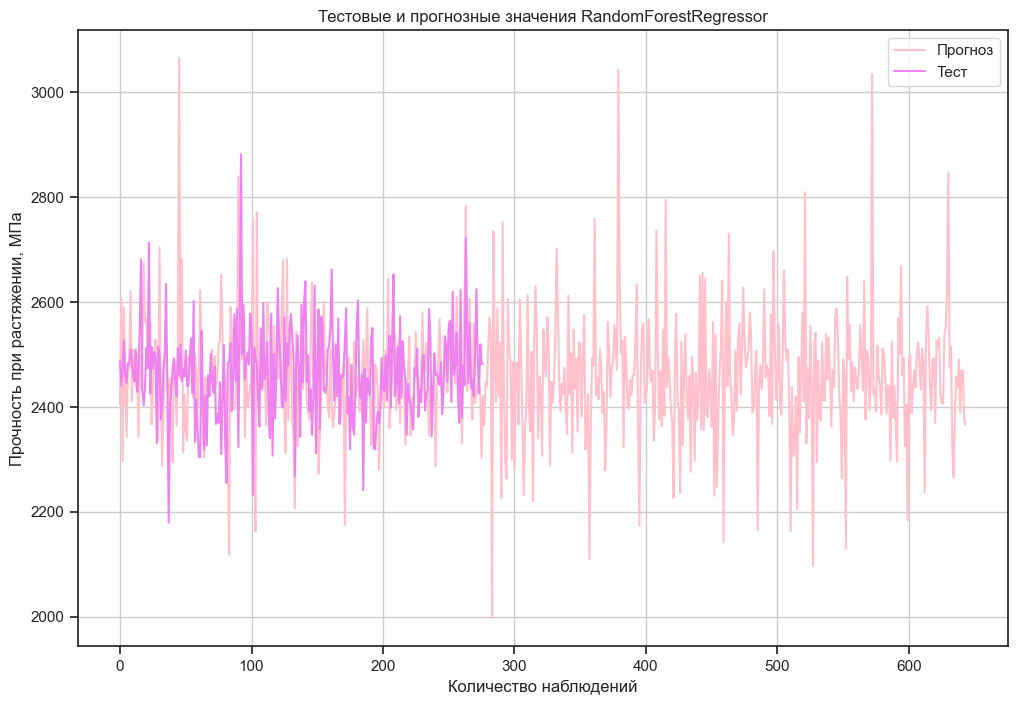

In [43]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения RandomForestRegressor")
plt.plot(y_pred_train_rfr_s, label = "Прогноз", color = "pink")
plt.plot(np.ravel(y_pred_test_rfr_s), label = "Тест", color = "violet")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True)

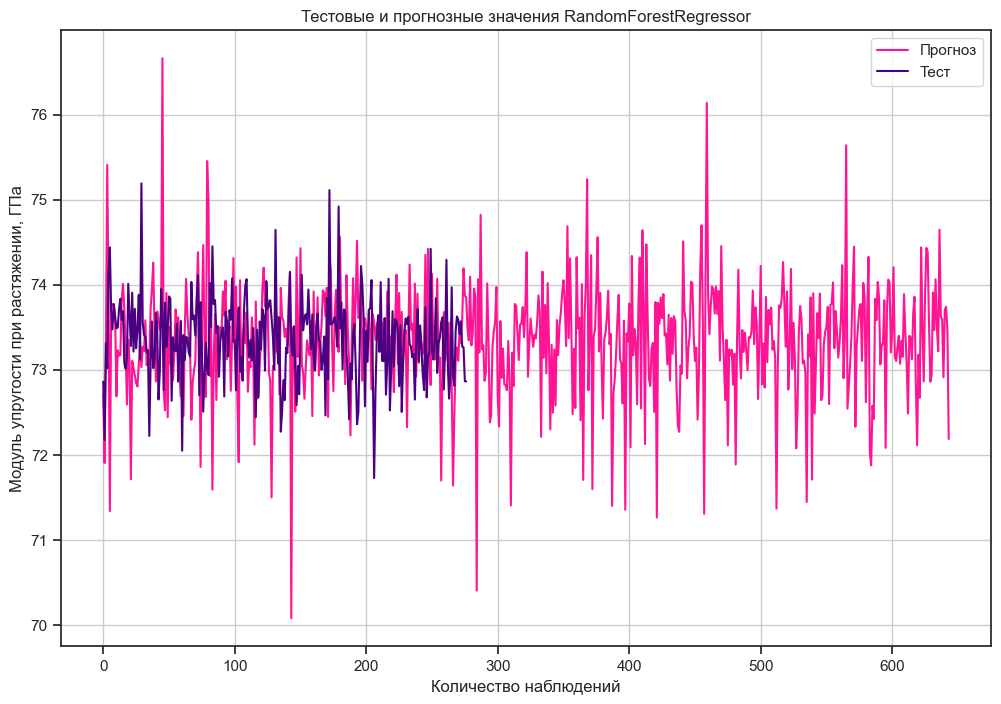

In [44]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения RandomForestRegressor")
plt.plot(y_pred_train_rfr_e, label = "Прогноз", color = '#FF1493')
plt.plot(np.ravel(y_pred_test_rfr_e), label = "Тест", color = "indigo")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True)

In [26]:
# выполним поиск гиперпараметров с помощью поиска по сетке с перекрёстной проверкой 

In [45]:
rfr_params = {'n_estimators': [150, 200, 250, 300],
              'max_depth': [5, 20],
              'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] }
GSCV_rfr_e = GridSearchCV(rfr, rfr_params, n_jobs=-1, cv=10)
GSCV_rfr_e.fit(X_train_e, y_train_e)
GSCV_rfr_e.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_rfr_e.best_params_} и результатом {GSCV_rfr_e.best_score_:.4f}')


Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 200} и результатом -0.0623


Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 200} и результатом -0.0623```

In [46]:
GSCV_rfr_s = GridSearchCV(rfr, rfr_params, n_jobs=-1, cv=10)
GSCV_rfr_s.fit(X_train_s, y_train_s)
GSCV_rfr_s.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_rfr_s.best_params_} и результатом {GSCV_rfr_s.best_score_:.4f}')


Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 150} и результатом -0.0329


Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 150} и результатом -0.0329```

In [47]:
best_model_rfr_e = GSCV_rfr_e.best_estimator_
best_model_rfr_s = GSCV_rfr_s.best_estimator_

In [48]:
print(best_model_rfr_e)

print(f'R2-score RFR для Модуля упругости при растяжении, МПа: {best_model_rfr_e.score(X_test_e, y_test_e).round(3)}')

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=200)
R2-score RFR для Модуля упругости при растяжении, МПа: -0.004


### Оценка моделей, средняя абсолютная ошибка и коэффициент детерминации

In [49]:
model_rfr_e = best_model_rfr_e.fit(X_train_e, y_train_e)
model_rfr_s = best_model_rfr_s.fit(X_train_s, y_train_s)


y_pred_test_rfr_e = model_rfr_e.predict(X_test_e)
y_pred_train_rfr_e = model_rfr_e.predict(X_train_e)
y_pred_test_rfr_s = model_rfr_s.predict(X_test_s)
y_pred_train_rfr_s = model_rfr_s.predict(X_train_s)

In [ ]:
print('MSE RandomForestRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_rfr_e), mean_squared_error(y_test_e, y_pred_test_rfr_e)))
print('R^2 RandomForestRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_rfr_e), r2_score(y_test_e, y_pred_test_rfr_e)))
print('MAE RandomForestRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_rfr_e), mean_absolute_error(y_test_e, y_pred_test_rfr_e)))
print('\n')
print('MSE RandomForestRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_rfr_s), mean_squared_error(y_test_s, y_pred_test_rfr_s)))
print('R^2 RandomForestRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_rfr_s), r2_score(y_test_s, y_pred_test_rfr_s)))
print('MAE RandomForestRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_rfr_s), mean_absolute_error(y_test_s, y_pred_test_rfr_s)))

MSE RandomForestRegressor(best) train_e: 6.8874, test_e: 9.1510
R^2 RandomForestRegressor(best) train_e: 0.2498, test_e: -0.0082
MAE RandomForestRegressor(best) train_e: 2.0923, test_e: 2.4501


MSE RandomForestRegressor(best) train_s: 150521.6349, test_s: 226238.0916
R^2 RandomForestRegressor(best) train_s: 0.2288, test_s: -0.0054
MAE RandomForestRegressor(best) train_s: 305.7443, test_s: 384.2891


# Модель Лассо регрессия. 

In [91]:
# Лассо регрессия
lasso = Lasso()
Lasso_e = Lasso()
Lasso_e.fit(X_train_e, y_train_e)
y_pred_test_Lasso_e = Lasso_e.predict(X_test_e)
y_pred_train_Lasso_e = Lasso_e.predict(X_train_e)
Lasso_s = Lasso()
Lasso_s.fit(X_train_s, y_train_s)
y_pred_test_Lasso_s = Lasso_s.predict(X_test_s)
y_pred_train_Lasso_s = Lasso_s.predict(X_train_s)

print('MSE Lasso train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_Lasso_e), mean_squared_error(y_test_e, y_pred_test_Lasso_e)))
print('R^2 Lasso train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_Lasso_e), r2_score(y_test_e, y_pred_test_Lasso_e)))
print('MAE Lasso train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_Lasso_e), mean_absolute_error(y_test_e, y_pred_test_Lasso_e)))
print('\n')
print('MSE Lasso train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_Lasso_s), mean_squared_error(y_test_s, y_pred_test_Lasso_s)))
print('R^2 Lasso train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_Lasso_s), r2_score(y_test_s, y_pred_test_Lasso_s)))
print('MAE Lasso train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_Lasso_s), mean_absolute_error(y_test_s, y_pred_test_Lasso_s)))

MSE Lasso train_e: 9.1087, test_e: 9.0485
R^2 Lasso train_e: 0.0078, test_e: 0.0031
MAE Lasso train_e: 2.4409, test_e: 2.4471


MSE Lasso train_s: 191764.4221, test_s: 224528.2006
R^2 Lasso train_s: 0.0175, test_s: 0.0022
MAE Lasso train_s: 348.1372, test_s: 384.1102


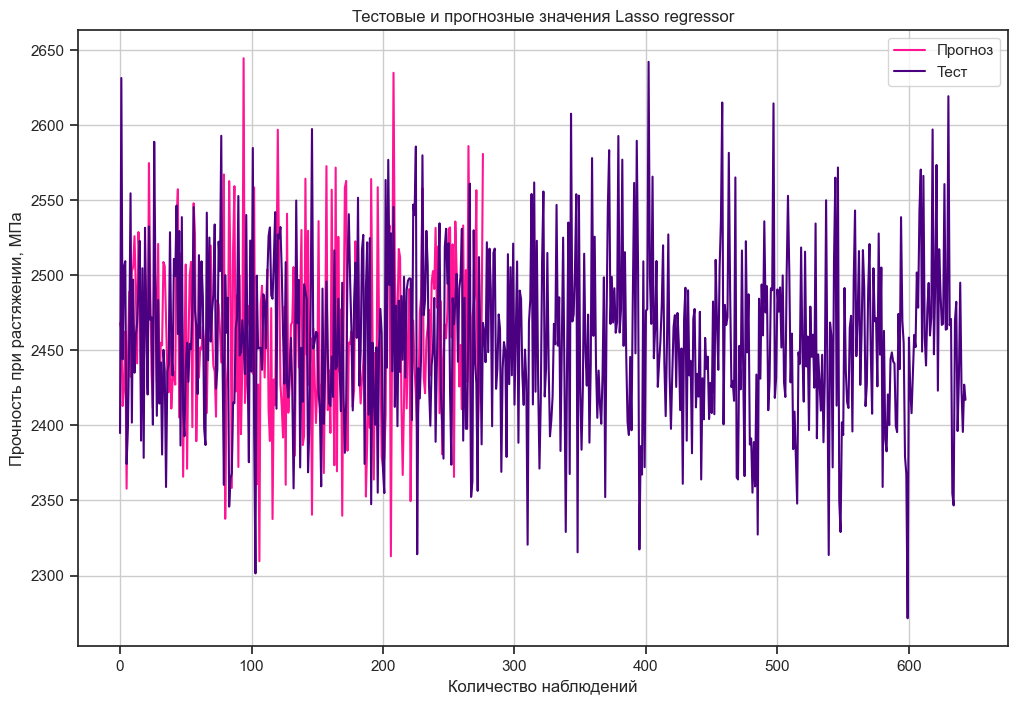

In [54]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения Lasso regressor")
plt.plot(y_pred_test_Lasso_s, label = "Прогноз", color = '#FF1493')
plt.plot(y_pred_train_Lasso_s, label = "Тест", color = "indigo")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True)

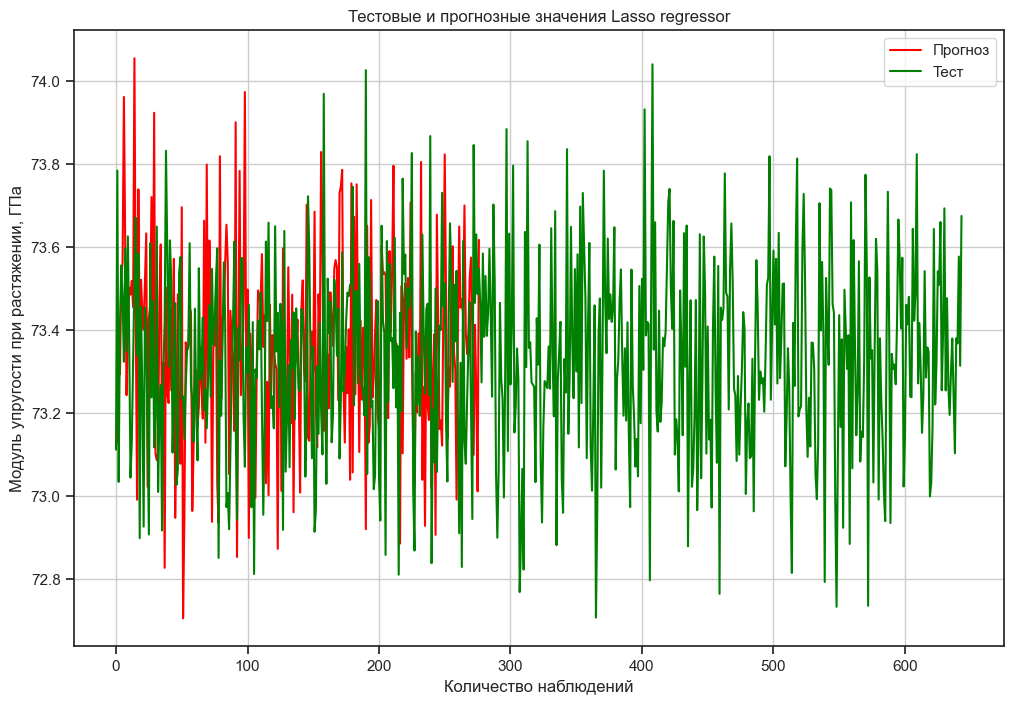

In [55]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения Lasso regressor")
plt.plot(y_pred_test_Lasso_e, label = "Прогноз", color = 'red')
plt.plot(y_pred_train_Lasso_e, label = "Тест", color = "green")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True)

In [56]:
lasso_params = {'alpha': [0.5, 1.5, 5, 10],
              'max_iter': [400, 700, 1200, 2000]}
GSCV_lasso_e = GridSearchCV(lasso, lasso_params, n_jobs=-1, cv=10)
GSCV_lasso_e.fit(X_train_e, y_train_e)
GSCV_lasso_e.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_lasso_e.best_params_} и результатом {GSCV_lasso_e.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 10, 'max_iter': 400} и результатом -0.0294


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 10, 'max_iter': 400} и результатом -0.0294```

In [57]:
GSCV_lasso_s = GridSearchCV(lasso, lasso_params, n_jobs=-1, cv=10)
GSCV_lasso_s.fit(X_train_s, y_train_s)
GSCV_lasso_s.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_lasso_s.best_params_} и результатом {GSCV_lasso_s.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 10, 'max_iter': 400} и результатом -0.0354


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 10, 'max_iter': 400} и результатом -0.0354```

In [58]:
best_model_lasso_e = GSCV_lasso_e.best_estimator_
best_model_lasso_s = GSCV_lasso_s.best_estimator_

In [59]:
print(best_model_lasso_e)

print(f'R2-score Lasso для Модуля упругости при растяжении, МПа: {best_model_lasso_e.score(X_test_e, y_test_e).round(3)}')

Lasso(alpha=10, max_iter=400)
R2-score Lasso для Модуля упругости при растяжении, МПа: -0.002


In [60]:
model_lasso_e = best_model_lasso_e.fit(X_train_e, y_train_e)
model_lasso_s = best_model_lasso_s.fit(X_train_s, y_train_s)


y_pred_test_lasso_e = model_lasso_e.predict(X_test_e)
y_pred_train_lasso_e = model_lasso_e.predict(X_train_e)
y_pred_test_lasso_s = model_lasso_s.predict(X_test_s)
y_pred_train_lasso_s = model_lasso_s.predict(X_train_s)

In [61]:
print('MSE Lasso(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_lasso_e), mean_squared_error(y_test_e, y_pred_test_lasso_e)))
print('R^2 Lasso(best) train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_lasso_e), r2_score(y_test_e, y_pred_test_lasso_e)))
print('MAE Lasso(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_lasso_e), mean_absolute_error(y_test_e, y_pred_test_lasso_e)))
print('\n')
print('MSE Lasso(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_lasso_s), mean_squared_error(y_test_s, y_pred_test_lasso_s)))
print('R^2 Lasso(best) train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_lasso_s), r2_score(y_test_s, y_pred_test_lasso_s)))
print('MAE Lasso(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_lasso_s), mean_absolute_error(y_test_s, y_pred_test_lasso_s)))

MSE Lasso(best) train_e: 9.1642, test_e: 9.0960
R^2 Lasso(best) train_e: 0.0017, test_e: -0.0021
MAE Lasso(best) train_e: 2.4453, test_e: 2.4543


MSE Lasso(best) train_s: 191887.4816, test_s: 223679.5537
R^2 Lasso(best) train_s: 0.0169, test_s: 0.0060
MAE Lasso(best) train_s: 348.3619, test_s: 383.0815


# Модель DecisionTreeRegressor

In [62]:
dtr = DecisionTreeRegressor()
dtr_e = DecisionTreeRegressor()
dtr_s = DecisionTreeRegressor()
dtr_e.fit(X_train_e, y_train_e)
dtr_s.fit(X_train_s, y_train_s)

y_pred_test_dtr_e = dtr_e.predict(X_test_e)
y_pred_train_dtr_e = dtr_e.predict(X_train_e)
y_pred_test_dtr_s = dtr_s.predict(X_test_s)
y_pred_train_dtr_s = dtr_s.predict(X_train_s)


print('MSE DecisionTreeRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_dtr_e), mean_squared_error(y_test_e, y_pred_test_dtr_e)))
print('R^2 DecisionTreeRegressor train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_dtr_e), r2_score(y_test_e, y_pred_test_dtr_e)))
print('MAE DecisionTreeRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_dtr_e), mean_absolute_error(y_test_e, y_pred_test_dtr_e)))
print('\n')
print('MSE DecisionTreeRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_dtr_s), mean_squared_error(y_test_s, y_pred_test_dtr_s)))
print('R^2 DecisionTreeRegressor train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_dtr_s), r2_score(y_test_s, y_pred_test_dtr_s)))
print('MAE DecisionTreeRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_dtr_s), mean_absolute_error(y_test_s, y_pred_test_dtr_s)))



MSE DecisionTreeRegressor train_e: 0.0000, test_e: 18.7589
R^2 DecisionTreeRegressor train_e: 1.0000, test_e: -1.0667
MAE DecisionTreeRegressor train_e: 0.0000, test_e: 3.5058


MSE DecisionTreeRegressor train_s: 0.0000, test_s: 412531.9984
R^2 DecisionTreeRegressor train_s: 1.0000, test_s: -0.8332
MAE DecisionTreeRegressor train_s: 0.0000, test_s: 505.6368


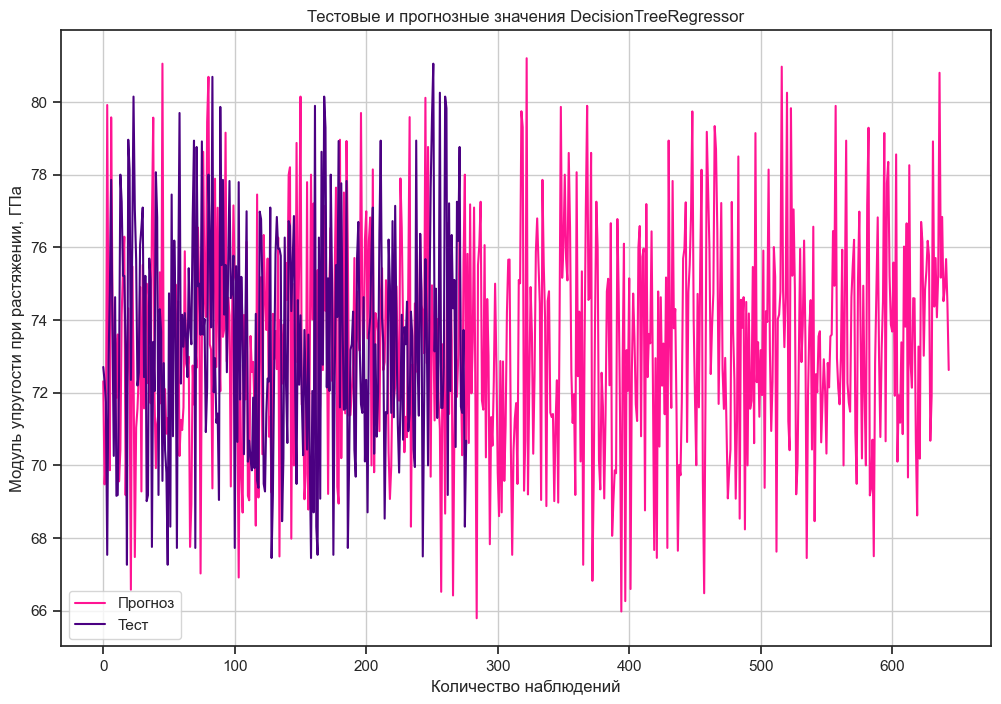

In [63]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения DecisionTreeRegressor")
plt.plot(y_pred_train_dtr_e, label = "Прогноз", color = '#FF1493')
plt.plot(np.ravel(y_pred_test_dtr_e), label = "Тест", color = "indigo")
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True)

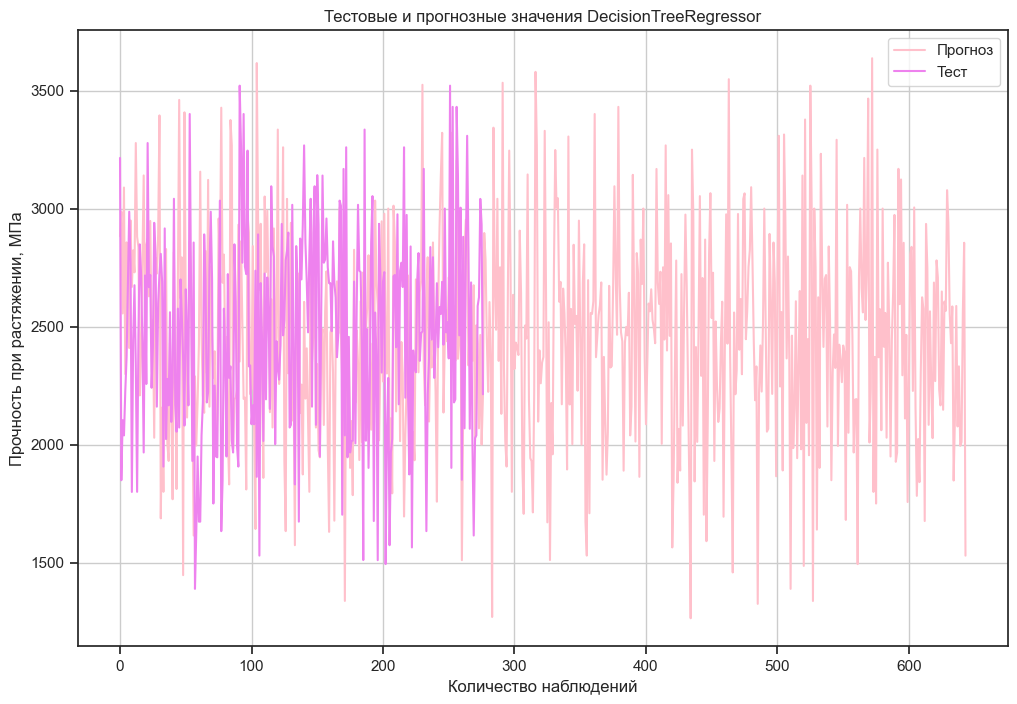

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Тестовые и прогнозные значения DecisionTreeRegressor")
plt.plot(y_pred_train_dtr_s, label = "Прогноз", color = "pink")
plt.plot(np.ravel(y_pred_test_dtr_s), label = "Тест", color = "violet")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True)

In [64]:
dtr_params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'splitter': ['best', 'random'],
              'max_depth': [5, 7, 10, 30, 50, 100, 1000],
              'max_features': ['auto', 'sqrt', 'log2'],
              'random_state': [42]}
GSCV_dtr_e = GridSearchCV(dtr, dtr_params, n_jobs=-1, cv=10)
GSCV_dtr_e.fit(X_train_e, y_train_e)
GSCV_dtr_e.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_dtr_e.best_params_} и результатом {GSCV_dtr_e.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0885


Результат: 
```Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0885```

In [65]:
GSCV_dtr_s = GridSearchCV(dtr, dtr_params, n_jobs=-1, cv=10)
GSCV_dtr_s.fit(X_train_s, y_train_s)
GSCV_dtr_s.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_dtr_s.best_params_} и результатом {GSCV_dtr_s.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0662


/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0662```

In [66]:
best_model_dtr_e = GSCV_dtr_e.best_estimator_
best_model_dtr_s = GSCV_dtr_s.best_estimator_

In [67]:
print(best_model_dtr_e)

print(f'R2-score DecisionTreeRegressor для Модуля упругости при растяжении, МПа: {best_model_dtr_e.score(X_test_e, y_test_e).round(3)}')

DecisionTreeRegressor(max_depth=5, max_features='sqrt', random_state=42,
                      splitter='random')
R2-score DecisionTreeRegressor для Модуля упругости при растяжении, МПа: -0.073


In [68]:
model_DTR_e = best_model_dtr_e.fit(X_train_e, y_train_e)
model_DTR_s = best_model_dtr_s.fit(X_train_s, y_train_s)


y_pred_test_DTR_e = model_DTR_e.predict(X_test_e)
y_pred_train_DTR_e = model_DTR_e.predict(X_train_e)
y_pred_test_DTR_s = model_DTR_s.predict(X_test_s)
y_pred_train_DTR_s = model_DTR_s.predict(X_train_s)

In [69]:
print('MSE DecisionTreeRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_DTR_e), mean_squared_error(y_test_e, y_pred_test_DTR_e)))
print('R^2 DecisionTreeRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_DTR_e), r2_score(y_test_e, y_pred_test_DTR_e)))
print('MAE DecisionTreeRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_DTR_e), mean_absolute_error(y_test_e, y_pred_test_DTR_e)))
print('\n')
print('MSE DecisionTreeRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_DTR_s), mean_squared_error(y_test_s, y_pred_test_DTR_s)))
print('R^2 DecisionTreeRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_DTR_s), r2_score(y_test_s, y_pred_test_DTR_s)))
print('MAE DecisionTreeRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_DTR_s), mean_absolute_error(y_test_s, y_pred_test_DTR_s)))


MSE DecisionTreeRegressor(best) train_e: 8.6243, test_e: 9.7378
R^2 DecisionTreeRegressor(best) train_e: 0.0606, test_e: -0.0728
MAE DecisionTreeRegressor(best) train_e: 2.3382, test_e: 2.5229


MSE DecisionTreeRegressor(best) train_s: 184036.1737, test_s: 229794.8330
R^2 DecisionTreeRegressor(best) train_s: 0.0571, test_s: -0.0212
MAE DecisionTreeRegressor(best) train_s: 332.8734, test_s: 386.5286


In [70]:
# список для средней абсолютной ошибки
MAE_y_strength = []
MAE_y_elastic = []
# список для коэффициента детерминации
R2_y_strength = []
R2_y_elastic = []

# Метод KNeighborsRegressor (К ближайших соседей) #

In [71]:
knr = KNeighborsRegressor()
knr_params = {'n_neighbors': range(1, 200), 
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
GSCV_knr_e = GridSearchCV(knr, knr_params, n_jobs=-1, cv=10)
GSCV_knr_e.fit(X_train_e, y_train_e)
GSCV_knr_e.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_knr_e.best_params_} и результатом {GSCV_knr_e.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 137, 'weights': 'uniform'} и результатом -0.0232


Результат: ```Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 137, 'weights': 'uniform'} и результатом -0.0232```

In [72]:
GSCV_knr_s = GridSearchCV(knr, knr_params, n_jobs=-1, cv=10)
GSCV_knr_s.fit(X_train_s, y_train_s)
GSCV_knr_s.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_knr_s.best_params_} и результатом {GSCV_knr_s.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 93, 'weights': 'uniform'} и результатом -0.0102


Результат: ```Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 93, 'weights': 'uniform'} и результатом -0.0102```

In [73]:
best_model_knr_e = GSCV_knr_e.best_estimator_
best_model_knr_s = GSCV_knr_s.best_estimator_

In [74]:
print(best_model_knr_e)

print(f'R2-score KNR для Модуля упругости при растяжении, МПа: {best_model_knr_e.score(X_test_e, y_test_e).round(3)}')

KNeighborsRegressor(n_neighbors=137)
R2-score KNR для Модуля упругости при растяжении, МПа: -0.018


In [75]:
model_knr_e = best_model_knr_e.fit(X_train_e, y_train_e)
model_knr_s = best_model_knr_s.fit(X_train_s, y_train_s)


y_pred_test_knr_e = model_knr_e.predict(X_test_e)
y_pred_train_knr_e = model_knr_e.predict(X_train_e)
y_pred_test_knr_s = model_knr_s.predict(X_test_s)
y_pred_train_knr_s = model_knr_s.predict(X_train_s)

In [76]:
print('MSE KNeighborsRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_knr_e), mean_squared_error(y_test_e, y_pred_test_knr_e)))
print('R^2 KNeighborsRegressor train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_knr_e), r2_score(y_test_e, y_pred_test_knr_e)))
print('MAE KNeighborsRegressor train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_knr_e), mean_absolute_error(y_test_e, y_pred_test_knr_e)))
print('\n')
print('MSE KNeighborsRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_knr_s), mean_squared_error(y_test_s, y_pred_test_knr_s)))
print('R^2 KNeighborsRegressor train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_knr_s), r2_score(y_test_s, y_pred_test_knr_s)))
print('MAE KNeighborsRegressor train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_knr_s), mean_absolute_error(y_test_s, y_pred_test_knr_s)))

MSE KNeighborsRegressor train_e: 9.0767, test_e: 9.2401
R^2 KNeighborsRegressor train_e: 0.0113, test_e: -0.0180
MAE KNeighborsRegressor train_e: 2.4322, test_e: 2.4806


MSE KNeighborsRegressor train_s: 190223.9471, test_s: 225364.1789
R^2 KNeighborsRegressor train_s: 0.0254, test_s: -0.0015
MAE KNeighborsRegressor train_s: 346.2832, test_s: 385.7366


# Стохастический градиентный спуск

In [77]:
sgd = SGDRegressor()
sgd_params = {'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
          'penalty': ['elasticnet', 'l2', 'l1'],
          'alpha': [0.0001, 0.001, 0.01, 0.0002, 0.002],
          'learning_rate': ['optimal', 'invscaling', 'adaptive'],
          'epsilon': [0.1, 0.01, 0.2, 0.02]
          }

In [78]:
GSCV_sgd_e = GridSearchCV(sgd, sgd_params, cv=10, verbose=0)
GSCV_sgd_e.fit(X_train_e, np.ravel(y_train_e))
GSCV_sgd_e.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_sgd_e.best_params_} и результатом {GSCV_sgd_e.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.02, 'learning_rate': 'adaptive', 'loss': 'huber', 'penalty': 'elasticnet'} и результатом -0.8242


Результат ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.02, 'learning_rate': 'adaptive', 'loss': 'huber', 'penalty': 'elasticnet'} и результатом -0.8242```

In [80]:
GSCV_sgd_s = GridSearchCV(sgd, sgd_params, cv=10, verbose=0)
GSCV_sgd_s.fit(X_train_s, np.ravel(y_train_s))
GSCV_sgd_s.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_sgd_s.best_params_} и результатом {GSCV_sgd_s.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.0002, 'epsilon': 0.02, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'penalty': 'l1'} и результатом -0.0884


Результат ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.0002, 'epsilon': 0.02, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'penalty': 'l1'} и результатом -0.0884```

In [81]:
best_model_sgd_e = GSCV_sgd_e.best_estimator_
best_model_sgd_s = GSCV_sgd_s.best_estimator_

In [82]:
print(best_model_sgd_e)

print(f'R2-score SGD для Модуля упругости при растяжении, МПа: {best_model_sgd_e.score(X_test_e, y_test_e).round(3)}')

SGDRegressor(alpha=0.01, epsilon=0.02, learning_rate='adaptive', loss='huber',
             penalty='elasticnet')
R2-score SGD для Модуля упругости при растяжении, МПа: -0.68


In [83]:
model_sgd_e = best_model_sgd_e.fit(X_train_e, y_train_e)
model_sgd_s = best_model_sgd_s.fit(X_train_s, y_train_s)


y_pred_test_sgd_e = model_sgd_e.predict(X_test_e)
y_pred_train_sgd_e = model_sgd_e.predict(X_train_e)
y_pred_test_sgd_s = model_sgd_s.predict(X_test_s)
y_pred_train_sgd_s = model_sgd_s.predict(X_train_s)

In [84]:
print('MSE SGDRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_sgd_e), mean_squared_error(y_test_e, y_pred_test_sgd_e)))
print('R^2 SGDRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_sgd_e), r2_score(y_test_e, y_pred_test_sgd_e)))
print('MAE SGDRegressor(best) train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_sgd_e), mean_absolute_error(y_test_e, y_pred_test_sgd_e)))
print('\n')
print('MSE SGDRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_sgd_s), mean_squared_error(y_test_s, y_pred_test_sgd_s)))
print('R^2 SGDRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_sgd_s), r2_score(y_test_s, y_pred_test_sgd_s)))
print('MAE SGDRegressor(best) train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_sgd_s), mean_absolute_error(y_test_s, y_pred_test_sgd_s)))

MSE SGDRegressor(best) train_e: 16.4760, test_e: 15.3740
R^2 SGDRegressor(best) train_e: -0.7947, test_e: -0.6938
MAE SGDRegressor(best) train_e: 3.2687, test_e: 3.2256


MSE SGDRegressor(best) train_s: 216378.0788, test_s: 263885.3112
R^2 SGDRegressor(best) train_s: -0.1086, test_s: -0.1727
MAE SGDRegressor(best) train_s: 368.6177, test_s: 417.0691


# Ridge regression 

In [92]:
ridge_params = [{'alpha': [20, 10, 1, 0.1, 0.01, 0.0001],
           "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}]

ridge = Ridge()
cv_scheme = KFold(n_splits=10, shuffle=True, random_state=1)
GSCV_ridge_e = GridSearchCV(estimator=ridge, param_grid=ridge_params, scoring='neg_root_mean_squared_error', cv=cv_scheme, return_train_score=True, n_jobs=-1)
GSCV_ridge_e.fit(X_train_e, y_train_e)
GSCV_ridge_e.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_ridge_e.best_params_} и результатом {GSCV_ridge_e.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'saga'} и результатом -3.0650


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Результат ```Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'saga'} и результатом -3.0650```

In [93]:
GSCV_ridge_s = GridSearchCV(estimator=ridge, param_grid=ridge_params, scoring='neg_root_mean_squared_error', cv=cv_scheme, return_train_score=True, n_jobs=-1)
GSCV_ridge_s.fit(X_train_s, y_train_s)
GSCV_ridge_s.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_ridge_s.best_params_} и результатом {GSCV_ridge_s.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'saga'} и результатом -444.9905


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Результат ```Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'saga'} и результатом -444.9905```

In [94]:
best_model_ridge_e = GSCV_ridge_e.best_estimator_
best_model_ridge_s = GSCV_ridge_s.best_estimator_

In [95]:
print(best_model_ridge_e)

print(f'R2-score Ridge для Модуля упругости при растяжении, МПа: {best_model_ridge_e.score(X_test_e, y_test_e)}')

Ridge(alpha=20, solver='saga')
R2-score Ridge для Модуля упругости при растяжении, МПа: 0.0036231576298206836


In [96]:
model_ridge_e = best_model_ridge_e.fit(X_train_e, y_train_e)
model_ridge_s = best_model_ridge_s.fit(X_train_s, y_train_s)


y_pred_test_ridge_e = model_ridge_e.predict(X_test_e)
y_pred_train_ridge_e = model_ridge_e.predict(X_train_e)
y_pred_test_ridge_s = model_ridge_s.predict(X_test_s)
y_pred_train_ridge_s = model_ridge_s.predict(X_train_s)

In [97]:
print('MSE Ridge regression train_e: {:.4f}, test_e: {:.4f}'.format(mean_squared_error(y_train_e, y_pred_train_ridge_e), mean_squared_error(y_test_e, y_pred_test_ridge_e)))
print('R^2 Ridge regression train_e: {:.4f}, test_e: {:.4f}'.format(r2_score(y_train_e, y_pred_train_ridge_e), r2_score(y_test_e, y_pred_test_ridge_e)))
print('MAE Ridge regression train_e: {:.4f}, test_e: {:.4f}'.format(mean_absolute_error(y_train_e, y_pred_train_ridge_e), mean_absolute_error(y_test_e, y_pred_test_ridge_e)))
print('\n')
print('MSE Ridge regression train_s: {:.4f}, test_s: {:.4f}'.format(mean_squared_error(y_train_s, y_pred_train_ridge_s), mean_squared_error(y_test_s, y_pred_test_ridge_s)))
print('R^2 Ridge regression train_s: {:.4f}, test_s: {:.4f}'.format(r2_score(y_train_s, y_pred_train_ridge_s), r2_score(y_test_s, y_pred_test_ridge_s)))
print('MAE Ridge regression train_s: {:.4f}, test_s: {:.4f}'.format(mean_absolute_error(y_train_s, y_pred_train_ridge_s), mean_absolute_error(y_test_s, y_pred_test_ridge_s)))

MSE Ridge regression train_e: 9.0739, test_e: 9.0440
R^2 Ridge regression train_e: 0.0116, test_e: 0.0036
MAE Ridge regression train_e: 2.4419, test_e: 2.4490


MSE Ridge regression train_s: 191839.1980, test_s: 223790.0397
R^2 Ridge regression train_s: 0.0172, test_s: 0.0055
MAE Ridge regression train_s: 348.3967, test_s: 383.4161


# Попробуем обучить модель на нормализованных данных.

In [98]:
df_norm = pd.read_csv('Datasets/df_norm.csv')
df_norm.head(2)

,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0,0.274768,0.651097,0.452951,0.079153,0.607435,0.509164,0.16223,0.272962,0.733127,0.514688,0.0,0.289334,0.546433
1,1,0.274768,0.651097,0.452951,0.630983,0.418887,0.583596,0.16223,0.272962,0.733127,0.514688,0.0,0.362355,0.319758


In [99]:
df_elastic_norm = df_norm.drop(['Модуль упругости при растяжении, ГПа', 'Unnamed: 0'], axis=1)
df_elastic_norm.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.274768,0.651097,0.452951,0.079153,0.607435,0.509164,0.16223,0.733127,0.514688,0.0,0.289334,0.546433
1,0.274768,0.651097,0.452951,0.630983,0.418887,0.583596,0.16223,0.733127,0.514688,0.0,0.362355,0.319758


In [100]:
df_strength_norm = df_norm.drop(['Прочность при растяжении, МПа', 'Unnamed: 0'], axis=1)
df_strength_norm.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.274768,0.651097,0.452951,0.079153,0.607435,0.509164,0.16223,0.272962,0.514688,0.0,0.289334,0.546433
1,0.274768,0.651097,0.452951,0.630983,0.418887,0.583596,0.16223,0.272962,0.514688,0.0,0.362355,0.319758


In [101]:
target_elastic_norm = df_norm['Модуль упругости при растяжении, ГПа']
target_elastic_norm.head(2)

0    0.272962
1    0.272962
Name: Модуль упругости при растяжении, ГПа, dtype: float64

In [102]:
target_strength_norm = df_norm['Прочность при растяжении, МПа']
target_strength_norm.head(2)

0    0.733127
1    0.733127
Name: Прочность при растяжении, МПа, dtype: float64

In [103]:
X_train_e_n, X_test_e_n, y_train_e_n, y_test_e_n = train_test_split(df_elastic_norm, target_elastic_norm, test_size=0.3, random_state=42)

X_train_s_n, X_test_s_n, y_train_s_n, y_test_s_n = train_test_split(df_strength_norm, target_strength_norm, test_size=0.3, random_state=42)

In [104]:
print(X_train_e_n.shape)
print(X_test_e_n.shape)
print(y_train_e_n.shape)
print(y_test_e_n.shape)

print(X_train_s_n.shape)
print(X_test_s_n.shape)
print(y_train_s_n.shape)
print(y_test_s_n.shape)

(644, 12)
(277, 12)
(644,)
(277,)
(644, 12)
(277, 12)
(644,)
(277,)


In [105]:
X_train_e_n.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
481,0.426214,0.487790,0.541014,0.834988,0.398340,0.535334,0.417296,0.684057,0.350148,1.0,0.603851,0.584834
650,0.716872,0.103244,0.564292,0.196869,0.405459,0.220791,0.601327,0.727529,0.793773,1.0,0.325750,0.680776


In [106]:
X_train_s_n.head(2)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
481,0.426214,0.487790,0.541014,0.834988,0.398340,0.535334,0.417296,0.423088,0.350148,1.0,0.603851,0.584834
650,0.716872,0.103244,0.564292,0.196869,0.405459,0.220791,0.601327,0.239054,0.793773,1.0,0.325750,0.680776


In [107]:
y_train_e_n.head(2)

481    0.423088
650    0.239054
Name: Модуль упругости при растяжении, ГПа, dtype: float64

In [108]:
knr = KNeighborsRegressor()
knr_params = {'n_neighbors': range(1, 200), 
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
GSCV_knr_e_n = GridSearchCV(knr, knr_params, n_jobs=-1, cv=10)
GSCV_knr_e_n.fit(X_train_e_n, y_train_e_n)
GSCV_knr_e_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_knr_e_n.best_params_} и результатом {GSCV_knr_e_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 199, 'weights': 'uniform'} и результатом -0.0211


Результат: ```Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 199, 'weights': 'uniform'} и результатом -0.0211```

In [109]:
GSCV_knr_s_n = GridSearchCV(knr, knr_params, n_jobs=-1, cv=10)
GSCV_knr_s_n.fit(X_train_s_n, y_train_s_n)
GSCV_knr_s_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_knr_s_n.best_params_} и результатом {GSCV_knr_s_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 32, 'weights': 'uniform'} и результатом -0.0221


Результат: ```Лучшая модель на кросс-валидации с параметрами {'algorithm': 'auto', 'n_neighbors': 32, 'weights': 'uniform'} и результатом -0.0221```

In [110]:
best_model_knr_e_n = GSCV_knr_e_n.best_estimator_
best_model_knr_s_n = GSCV_knr_s_n.best_estimator_

In [111]:
print(best_model_knr_e_n)

print(f'R2-score KNR для Модуля упругости при растяжении, МПа: {best_model_knr_e_n.score(X_test_e_n, y_test_e_n).round(3)}')

KNeighborsRegressor(n_neighbors=199)
R2-score KNR для Модуля упругости при растяжении, МПа: 0.001


In [112]:
model_knr_e_n = best_model_knr_e_n.fit(X_train_e_n, y_train_e_n)
model_knr_s_n = best_model_knr_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_knr_e_n = model_knr_e_n.predict(X_test_e_n)
y_pred_train_knr_e_n = model_knr_e_n.predict(X_train_e_n)
y_pred_test_knr_s_n = model_knr_s_n.predict(X_test_s_n)
y_pred_train_knr_s_n = model_knr_s_n.predict(X_train_s_n)

In [113]:
print('MSE KNeighborsRegressor train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_knr_e_n), mean_squared_error(y_test_e_n, y_pred_test_knr_e_n)))
print('R^2 KNeighborsRegressor train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_knr_e_n), r2_score(y_test_e_n, y_pred_test_knr_e_n)))
print('MAE KNeighborsRegressor train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_knr_e_n), mean_absolute_error(y_test_e_n, y_pred_test_knr_e_n)))
print('\n')
print('MSE KNeighborsRegressor train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_knr_s_n), mean_squared_error(y_test_s_n, y_pred_test_knr_s_n)))
print('R^2 KNeighborsRegressor train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_knr_s_n), r2_score(y_test_s_n, y_pred_test_knr_s_n)))
print('MAE KNeighborsRegressor train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_knr_s_n), mean_absolute_error(y_test_s_n, y_pred_test_knr_s_n)))

MSE KNeighborsRegressor train_e_n: 0.0385, test_e_n: 0.0382
R^2 KNeighborsRegressor train_e_n: 0.0055, test_e_n: 0.0010
MAE KNeighborsRegressor train_e_n: 0.1584, test_e_n: 0.1591


MSE KNeighborsRegressor train_s_n: 0.0326, test_s_n: 0.0406
R^2 KNeighborsRegressor train_s_n: 0.0488, test_s_n: -0.0276
MAE KNeighborsRegressor train_s_n: 0.1435, test_s_n: 0.1636


In [114]:
lasso_params = {'alpha': [0.5, 1.5, 5, 10],
              'max_iter': [400, 700, 1200, 2000]}
GSCV_lasso_e_n = GridSearchCV(lasso, lasso_params, n_jobs=-1, cv=10)
GSCV_lasso_e_n.fit(X_train_e_n, y_train_e_n)
GSCV_lasso_e_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_lasso_e_n.best_params_} и результатом {GSCV_lasso_e_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.5, 'max_iter': 400} и результатом -0.0202


Результат:  ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.5, 'max_iter': 400} и результатом -0.0202```

In [115]:
GSCV_lasso_s_n = GridSearchCV(lasso, lasso_params, n_jobs=-1, cv=10)
GSCV_lasso_s_n.fit(X_train_s_n, y_train_s_n)
GSCV_lasso_s_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_lasso_s_n.best_params_} и результатом {GSCV_lasso_s_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.5, 'max_iter': 400} и результатом -0.0257


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.5, 'max_iter': 400} и результатом -0.0257```

In [116]:
best_model_lasso_e_n = GSCV_lasso_e_n.best_estimator_
best_model_lasso_s_n = GSCV_lasso_s_n.best_estimator_

In [117]:
print(best_model_lasso_e_n)

print(f'R2-score Lasso для Модуля упругости при растяжении, МПа: {best_model_lasso_e_n.score(X_test_e_n, y_test_e_n).round(3)}')

Lasso(alpha=0.5, max_iter=400)
R2-score Lasso для Модуля упругости при растяжении, МПа: -0.001


In [118]:
model_lasso_e_n = best_model_lasso_e_n.fit(X_train_e_n, y_train_e_n)
model_lasso_s_n = best_model_lasso_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_lasso_e_n = model_lasso_e_n.predict(X_test_e_n)
y_pred_train_lasso_e_n = model_lasso_e_n.predict(X_train_e_n)
y_pred_test_lasso_s_n = model_lasso_s_n.predict(X_test_s_n)
y_pred_train_lasso_s_n = model_lasso_s_n.predict(X_train_s_n)

In [119]:
print('MSE Lasso(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_lasso_e_n), mean_squared_error(y_test_e_n, y_pred_test_lasso_e_n)))
print('R^2 Lasso(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_lasso_e_n), r2_score(y_test_e_n, y_pred_test_lasso_e_n)))
print('MAE Lasso(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_lasso_e_n), mean_absolute_error(y_test_e_n, y_pred_test_lasso_e_n)))
print('\n')
print('MSE Lasso(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_lasso_s_n), mean_squared_error(y_test_s_n, y_pred_test_lasso_s_n)))
print('R^2 Lasso(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_lasso_s_n), r2_score(y_test_s, y_pred_test_lasso_s_n)))
print('MAE Lasso(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_lasso_s_n), mean_absolute_error(y_test_s_n, y_pred_test_lasso_s_n)))

MSE Lasso(best) train_e_n: 0.0387, test_e_n: 0.0383
R^2 Lasso(best) train_e_n: 0.0000, test_e_n: -0.0009
MAE Lasso(best) train_e_n: 0.1587, test_e_n: 0.1591


MSE Lasso(best) train_s_n: 0.0343, test_s_n: 0.0395
R^2 Lasso(best) train_s_n: 0.0000, test_s_n: -26.9966
MAE Lasso(best) train_s_n: 0.1469, test_s_n: 0.1607


In [120]:
dtr_params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'splitter': ['best', 'random'],
              'max_depth': [5, 7, 10, 30, 50, 100, 1000],
              'max_features': ['auto', 'sqrt', 'log2'],
              'random_state': [42]}
GSCV_dtr_e_n = GridSearchCV(dtr, dtr_params, n_jobs=-1, cv=10)
GSCV_dtr_e_n.fit(X_train_e_n, y_train_e_n)
GSCV_dtr_e_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_dtr_e_n.best_params_} и результатом {GSCV_dtr_e_n.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0837


/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0837```

In [121]:
GSCV_dtr_s_n = GridSearchCV(dtr, dtr_params, n_jobs=-1, cv=10)
GSCV_dtr_s_n.fit(X_train_s_n, y_train_s_n)
GSCV_dtr_s_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_dtr_s_n.best_params_} и результатом {GSCV_dtr_s_n.best_score_:.4f}')

/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0660


/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.11/si

Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'random'} и результатом -0.0660```

In [122]:
best_model_dtr_e_n = GSCV_dtr_e_n.best_estimator_
best_model_dtr_s_n = GSCV_dtr_s_n.best_estimator_

In [123]:
print(best_model_dtr_e_n)

print(f'R2-score DecisionTreeRegressor для Модуля упругости при растяжении, МПа: {best_model_dtr_e_n.score(X_test_e_n, y_test_e_n).round(3)}')

DecisionTreeRegressor(max_depth=5, max_features='sqrt', random_state=42,
                      splitter='random')
R2-score DecisionTreeRegressor для Модуля упругости при растяжении, МПа: -0.073


In [124]:
model_DTR_e_n = best_model_dtr_e_n.fit(X_train_e_n, y_train_e_n)
model_DTR_s_n = best_model_dtr_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_DTR_e_n = model_DTR_e_n.predict(X_test_e_n)
y_pred_train_DTR_e_n = model_DTR_e_n.predict(X_train_e_n)
y_pred_test_DTR_s_n = model_DTR_s_n.predict(X_test_s_n)
y_pred_train_DTR_s_n = model_DTR_s_n.predict(X_train_s_n)

In [125]:
print('MSE DecisionTreeRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_DTR_e_n), mean_squared_error(y_test_e_n, y_pred_test_DTR_e_n)))
print('R^2 DecisionTreeRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_DTR_e_n), r2_score(y_test_e_n, y_pred_test_DTR_e_n)))
print('MAE DecisionTreeRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_DTR_e_n), mean_absolute_error(y_test_e_n, y_pred_test_DTR_e_n)))
print('\n')
print('MSE DecisionTreeRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_DTR_s_n), mean_squared_error(y_test_s_n, y_pred_test_DTR_s_n)))
print('R^2 DecisionTreeRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_DTR_s_n), r2_score(y_test_s_n, y_pred_test_DTR_s_n)))
print('MAE DecisionTreeRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_DTR_s_n), mean_absolute_error(y_test_s_n, y_pred_test_DTR_s_n)))

MSE DecisionTreeRegressor(best) train_e_n: 0.0363, test_e_n: 0.0410
R^2 DecisionTreeRegressor(best) train_e_n: 0.0606, test_e_n: -0.0728
MAE DecisionTreeRegressor(best) train_e_n: 0.1517, test_e_n: 0.1637


MSE DecisionTreeRegressor(best) train_s_n: 0.0323, test_s_n: 0.0403
R^2 DecisionTreeRegressor(best) train_s_n: 0.0571, test_s_n: -0.0212
MAE DecisionTreeRegressor(best) train_s_n: 0.1395, test_s_n: 0.1620


In [126]:
rfr_params = {'n_estimators': [150, 200, 250, 300],
              'max_depth': [5, 20],
              'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] }
GSCV_rfr_e_n = GridSearchCV(rfr, rfr_params, n_jobs=-1, cv=10)
GSCV_rfr_e_n.fit(X_train_e_n, y_train_e_n)
GSCV_rfr_e_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_rfr_e_n.best_params_} и результатом {GSCV_rfr_e_n.best_score_:.4f}')


Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 250} и результатом -0.0633


Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 250} и результатом -0.0633```

In [127]:
GSCV_rfr_s_n = GridSearchCV(rfr, rfr_params, n_jobs=-1, cv=10)
GSCV_rfr_s_n.fit(X_train_s, y_train_s)
GSCV_rfr_s_n.best_params_
print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_rfr_s_n.best_params_} и результатом {GSCV_rfr_s_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 20, 'n_estimators': 300} и результатом -0.0343


Результат: ```Лучшая модель на кросс-валидации с параметрами {'criterion': 'absolute_error', 'max_depth': 20, 'n_estimators': 300} и результатом -0.0343```

In [128]:
best_model_rfr_e_n = GSCV_rfr_e_n.best_estimator_
best_model_rfr_s_n = GSCV_rfr_s_n.best_estimator_

In [129]:
print(best_model_rfr_e_n)

print(f'R2-score RFR для Модуля упругости при растяжении, МПа: {best_model_rfr_e_n.score(X_test_e_n, y_test_e_n).round(5)}')

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=250)
R2-score RFR для Модуля упругости при растяжении, МПа: -0.00524


In [130]:
model_rfr_e_n = best_model_rfr_e_n.fit(X_train_e_n, y_train_e_n)
model_rfr_s_n = best_model_rfr_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_rfr_e_n = model_rfr_e_n.predict(X_test_e_n)
y_pred_train_rfr_e_n = model_rfr_e_n.predict(X_train_e_n)
y_pred_test_rfr_s_n = model_rfr_s_n.predict(X_test_s_n)
y_pred_train_rfr_s_n = model_rfr_s_n.predict(X_train_s_n)

In [131]:
print('MSE RandomForestRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_rfr_e_n), mean_squared_error(y_test_e_n, y_pred_test_rfr_e_n)))
print('R^2 RandomForestRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_rfr_e_n), r2_score(y_test_e_n, y_pred_test_rfr_e_n)))
print('MAE RandomForestRegressor(best) train_e_: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_rfr_e_n), mean_absolute_error(y_test_e_n, y_pred_test_rfr_e_n)))
print('\n')
print('MSE RandomForestRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_rfr_s_n), mean_squared_error(y_test_s_n, y_pred_test_rfr_s_n)))
print('R^2 RandomForestRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_rfr_s_n), r2_score(y_test_s_n, y_pred_test_rfr_s_n)))
print('MAE RandomForestRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_rfr_s_n), mean_absolute_error(y_test_s_n, y_pred_test_rfr_s_n)))

MSE RandomForestRegressor(best) train_e_n: 0.0290, test_e_n: 0.0384
R^2 RandomForestRegressor(best) train_e_n: 0.2502, test_e_n: -0.0054
MAE RandomForestRegressor(best) train_e_: 0.1357, test_e_n: 0.1588


MSE RandomForestRegressor(best) train_s_n: 0.0061, test_s_n: 0.0403
R^2 RandomForestRegressor(best) train_s_n: 0.8226, test_s_n: -0.0193
MAE RandomForestRegressor(best) train_s_n: 0.0623, test_s_n: 0.1625


In [132]:
GSCV_sgd_e_n = GridSearchCV(sgd, sgd_params, cv=10, verbose=0)
GSCV_sgd_e_n.fit(X_train_e_n, np.ravel(y_train_e_n))
GSCV_sgd_e_n.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_sgd_e_n.best_params_} и результатом {GSCV_sgd_e_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'} и результатом -0.0196


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'} и результатом -0.0196```

In [133]:
GSCV_sgd_s_n = GridSearchCV(sgd, sgd_params, cv=10, verbose=0)
GSCV_sgd_s_n.fit(X_train_s_n, np.ravel(y_train_s_n))
GSCV_sgd_s_n.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_sgd_s_n.best_params_} и результатом {GSCV_sgd_s_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.2, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l1'} и результатом -0.0174


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 0.01, 'epsilon': 0.2, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l1'} и результатом -0.0174```

In [134]:
best_model_sgd_e_n = GSCV_sgd_e_n.best_estimator_
best_model_sgd_s_n = GSCV_sgd_s_n.best_estimator_

In [135]:
print(best_model_sgd_e_n)

print(f'R2-score SGD для Модуля упругости при растяжении, МПа: {best_model_sgd_e_n.score(X_test_e_n, y_test_e_n).round(5)}')

SGDRegressor(alpha=0.01, learning_rate='adaptive',
             loss='squared_epsilon_insensitive', penalty='l1')
R2-score SGD для Модуля упругости при растяжении, МПа: -0.00164


In [136]:
model_sgd_e_n = best_model_sgd_e_n.fit(X_train_e_n, y_train_e_n)
model_sgd_s_n = best_model_sgd_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_sgd_e_n = model_sgd_e_n.predict(X_test_e_n)
y_pred_train_sgd_e_n = model_sgd_e_n.predict(X_train_e_n)
y_pred_test_sgd_s_n = model_sgd_s_n.predict(X_test_s_n)
y_pred_train_sgd_s_n = model_sgd_s_n.predict(X_train_s_n)

In [137]:
print('MSE SGDRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_sgd_e_n), mean_squared_error(y_test_e_n, y_pred_test_sgd_e_n)))
print('R^2 SGDRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_sgd_e_n), r2_score(y_test_e_n, y_pred_test_sgd_e_n)))
print('MAE SGDRegressor(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_sgd_e_n), mean_absolute_error(y_test_e_n, y_pred_test_sgd_e_n)))
print('\n')
print('MSE SGDRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_sgd_s_n), mean_squared_error(y_test_s_n, y_pred_test_sgd_s_n)))
print('R^2 SGDRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_sgd_s_n), r2_score(y_test_s_n, y_pred_test_sgd_s_n)))
print('MAE SGDRegressor(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_sgd_s_n), mean_absolute_error(y_test_s_n, y_pred_test_sgd_s_n)))

MSE SGDRegressor(best) train_e_n: 0.0387, test_e_n: 0.0383
R^2 SGDRegressor(best) train_e_n: -0.0002, test_e_n: -0.0019
MAE SGDRegressor(best) train_e_n: 0.1588, test_e_n: 0.1591


MSE SGDRegressor(best) train_s_n: 0.0344, test_s_n: 0.0396
R^2 SGDRegressor(best) train_s_n: -0.0031, test_s_n: -0.0013
MAE SGDRegressor(best) train_s_n: 0.1473, test_s_n: 0.1611


In [138]:
GSCV_ridge_e_n = GridSearchCV(estimator=ridge, param_grid=ridge_params, scoring='neg_root_mean_squared_error', cv=cv_scheme, return_train_score=True, n_jobs=-1)
GSCV_ridge_e_n.fit(X_train_e_n, y_train_e_n)
GSCV_ridge_e_n.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_ridge_e_n.best_params_} и результатом {GSCV_ridge_e_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'sag'} и результатом -0.1980


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'sag'} и результатом -0.1980```

In [139]:
GSCV_ridge_s_n = GridSearchCV(estimator=ridge, param_grid=ridge_params, scoring='neg_root_mean_squared_error', cv=cv_scheme, return_train_score=True, n_jobs=-1)
GSCV_ridge_s_n.fit(X_train_s_n, y_train_s_n)
GSCV_ridge_s_n.best_params_

print(f'Лучшая модель на кросс-валидации с параметрами {GSCV_ridge_s_n.best_params_} и результатом {GSCV_ridge_s_n.best_score_:.4f}')

Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'lsqr'} и результатом -0.1859


Результат: ```Лучшая модель на кросс-валидации с параметрами {'alpha': 20, 'solver': 'lsqr'} и результатом -0.1859```

In [140]:
best_model_ridge_e_n = GSCV_ridge_e_n.best_estimator_
best_model_ridge_s_n = GSCV_ridge_s_n.best_estimator_

In [141]:
print(best_model_ridge_e_n)

print(f'R2-score Ridge для Модуля упругости при растяжении, МПа: {best_model_ridge_e_n.score(X_test_e_n, y_test_e_n)}')

Ridge(alpha=20, solver='sag')
R2-score Ridge для Модуля упругости при растяжении, МПа: 0.001085203395203016


In [142]:
model_ridge_e_n = best_model_ridge_e_n.fit(X_train_e_n, y_train_e_n)
model_ridge_s_n = best_model_ridge_s_n.fit(X_train_s_n, y_train_s_n)


y_pred_test_ridge_e_n = model_ridge_e_n.predict(X_test_e_n)
y_pred_train_ridge_e_n = model_ridge_e_n.predict(X_train_e_n)
y_pred_test_ridge_s_n = model_ridge_s_n.predict(X_test_s_n)
y_pred_train_ridge_s_n = model_ridge_s_n.predict(X_train_s_n)

In [143]:
print('MSE Ridge regression(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_squared_error(y_train_e_n, y_pred_train_ridge_e_n), mean_squared_error(y_test_e_n, y_pred_test_ridge_e_n)))
print('R^2 Ridge regression(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(r2_score(y_train_e_n, y_pred_train_ridge_e_n), r2_score(y_test_e_n, y_pred_test_ridge_e_n)))
print('MAE Ridge regression(best) train_e_n: {:.4f}, test_e_n: {:.4f}'.format(mean_absolute_error(y_train_e_n, y_pred_train_ridge_e_n), mean_absolute_error(y_test_e_n, y_pred_test_ridge_e_n)))
print('\n')
print('MSE Ridge regression(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_squared_error(y_train_s_n, y_pred_train_ridge_s_n), mean_squared_error(y_test_s_n, y_pred_test_ridge_s_n)))
print('R^2 Ridge regression(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(r2_score(y_train_s_n, y_pred_train_ridge_s_n), r2_score(y_test_s_n, y_pred_test_ridge_s_n)))
print('MAE Ridge regression(best) train_s_n: {:.4f}, test_s_n: {:.4f}'.format(mean_absolute_error(y_train_s_n, y_pred_train_ridge_s_n), mean_absolute_error(y_test_s_n, y_pred_test_ridge_s_n)))

MSE Ridge regression(best) train_e_n: 0.0382, test_e_n: 0.0382
R^2 Ridge regression(best) train_e_n: 0.0116, test_e_n: 0.0011
MAE Ridge regression(best) train_e_n: 0.1582, test_e_n: 0.1593


MSE Ridge regression(best) train_s_n: 0.0338, test_s_n: 0.0394
R^2 Ridge regression(best) train_s_n: 0.0136, test_s_n: 0.0026
MAE Ridge regression(best) train_s_n: 0.1460, test_s_n: 0.1608


# Общая таблица полученных данных при построении и обучении моделей 

In [181]:
df_mresult = pd.read_excel('models/models_result.xlsx')

df_mresult.dropna(how='all', inplace=True, axis=1)
df_mresult.dropna(how='all', inplace=True, axis=0)
df_mresult.head(20)

,Unnamed: 0,Модуль упругости при растяжении,Модуль упругости при растяжении.1,Модуль упругости при растяжении.2,Модуль упругости при растяжении.3,Модуль упругости при растяжении.4,Модуль упругости при растяжении.5,Прочность при растяжении,Прочность при растяжении.1,Прочность при растяжении.2,Прочность при растяжении.3,Прочность при растяжении.4,Прочность при растяжении.5
0,NaN,MSE train,MSE test,R2 train,R2 test,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test,MAE train,MAE test
1,RandomForestRegressor,6.9005,9.2088,0.2483,-0.0145,2.1325,2.4773,141389.7205,224732.5402,0.2756,0.0013,300.0945,384.482
2,RandomForestRegressor_best,6.8874,9.151,0.2498,-0.0082,2.0923,2.4501,150521.6349,226238.0916,0.2288,-0.0054,305.7443,384.2891
3,RandomForestRegressor_norm,0.029,0.0384,0.2502,-0.0054,0.1357,0.1588,0.0061,0.0403,0.8226,-0.0193,0.0623,0.1625
5,Lasso,9.1087,9.0485,0.0078,0.0031,2.4409,2.4471,191764.4221,224528.2006,0.0175,0.0022,348.1372,384.1102
6,Lasso_best,9.1642,9.096,0.0017,-0.0021,2.4453,2.4543,191887.4816,223679.5537,0.0169,0.006,348.3619,383.0815
7,Lasso_norm,0.0387,0.0383,0,-0.0009,0.1587,0.1591,0.0343,0.0395,0,-26.9966,0.1469,0.1607
9,DecisionTreeRegressor,0,18.7589,1,-1.0667,0,3.5058,0,412531.9984,1,-0.8332,0,505.6368
10,DecisionTreeRegressor_best,8.6243,9.7378,0.0606,-0.0728,2.3382,2.5229,184036.1737,229794.833,0.0571,-0.0212,332.8734,386.5286
11,DecisionTreeRegressor_norm,0.0363,0.041,0.0606,-0.0728,0.1517,0.1637,0.0323,0.0403,0.0571,-0.0212,0.1395,0.162
